In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Load CSV file
filepath = Path.cwd().parent/"dataSet" / "player_stats.csv"
data = pd.read_csv(filepath, encoding='latin1')

#drop duplicate values
data = data.drop_duplicates()

# Remove dots and dollar signs, and convert to float
data['value'] = data['value'].replace('[^\d]', '', regex=True).astype(float)

# Remove null column and player column as the name should not affect the market value  
data.drop('marking', axis=1, inplace=True)
data.drop('player', axis=1, inplace=True)
encoded_df = data.drop(['country', 'club'], axis=1)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

GK_df = encoded_df[["gk_handling", "gk_kicking","gk_reflexes","gk_positioning","gk_diving"]]
#scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(GK_df)

# Apply PCA
pca = PCA(n_components=1)
principal_components = pca.fit_transform(scaled_data)

# Variance explained by the principal component
print(f"Explained Variance: {pca.explained_variance_ratio_}")

# Create DataFrame for principal components
principal_df = pd.DataFrame(data=principal_components, columns=['gk_Principal_Component'])

# Join the principal components DataFrame with the encoded dataset
encoded_df.drop(["gk_handling", "gk_kicking","gk_reflexes","gk_positioning","gk_diving"], axis=1, inplace=True)
encoded_df = encoded_df.merge(principal_df, left_index=True, right_index=True)
encoded_df.dtypes

Explained Variance: [0.97665296]


height                      int64
weight                      int64
age                         int64
ball_control                int64
dribbling                   int64
slide_tackle                int64
stand_tackle                int64
aggression                  int64
reactions                   int64
att_position                int64
interceptions               int64
vision                      int64
composure                   int64
crossing                    int64
short_pass                  int64
long_pass                   int64
acceleration                int64
stamina                     int64
strength                    int64
balance                     int64
sprint_speed                int64
agility                     int64
jumping                     int64
heading                     int64
shot_power                  int64
finishing                   int64
long_shots                  int64
curve                       int64
fk_acc                      int64
penalties     

In [4]:
# Separate features and target
X = encoded_df.drop('value', axis=1)  
y = encoded_df['value']

# Split the dataset into training and test sets (70% training, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size = 0.7, random_state=42)

# Further split the test set into training and validation sets (70% testing, 30% validation)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,train_size = 0.7, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_valid_scaled = scaler.transform(X_valid)

In [6]:
# Create SVR model
svm_model = SVR()

# Train the model
svm_model.fit(X_train_scaled, y_train)

# Predictions on the test set
y_pred = svm_model.predict(X_test_scaled)
y_pred
# Calculate evaluation metrics (MSE and R-squared)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared Score: {r2}')

Mean Squared Error (MSE): 54002818335301.51
R-squared Score: -0.09552641887621993


In [7]:
from sklearn.model_selection import GridSearchCV
# Define SVM model
svm_model = SVR()

# Define hyperparameters grid for tuning
param_grid = {'C': [85], 'kernel': ['poly'], 'gamma': [3.5]}

# Perform GridSearchCV
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Get best hyperparameters and score
best_params = grid_search.best_params_
print(f"Best param: {best_params}")
print(f"Best score: {grid_search.best_score_}")

best_svm_model = grid_search.best_estimator_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best param: {'C': 85, 'gamma': 3.5, 'kernel': 'poly'}
Best score: 0.5620874164268155


Training Sizes: [ 454 1362 2270 3178 4086 4540] 
 Training Scores: [[-3.82671112e+13 -2.92006947e+13 -2.92006947e+13 -2.92006947e+13
  -2.92006947e+13]
 [-4.69964709e+13 -4.74053684e+13 -4.31103465e+13 -4.31103465e+13
  -4.31103465e+13]
 [-4.32686472e+13 -4.35184610e+13 -4.43855211e+13 -4.43855211e+13
  -4.43855211e+13]
 [-4.92294632e+13 -4.94088423e+13 -5.00277511e+13 -4.48588705e+13
  -4.48588705e+13]
 [-5.03147389e+13 -5.04540287e+13 -5.09393838e+13 -4.56344421e+13
  -4.74424685e+13]
 [-6.50348858e+13 -6.29169801e+13 -6.33504694e+13 -5.85760624e+13
  -4.81683874e+13]] 
 test_scores : [[-4.45877943e+13 -4.41738627e+13 -4.24430493e+13 -6.15462998e+13
  -1.12155150e+14]
 [-4.46028685e+13 -4.41443614e+13 -4.24122700e+13 -6.15114945e+13
  -1.12116345e+14]
 [-4.45979049e+13 -4.41349425e+13 -4.24025746e+13 -6.15004824e+13
  -1.12104057e+14]
 [-4.45975125e+13 -4.41346121e+13 -4.24021365e+13 -6.15101764e+13
  -1.12114857e+14]
 [-4.45978870e+13 -4.41350568e+13 -4.24064667e+13 -6.15048812e+13


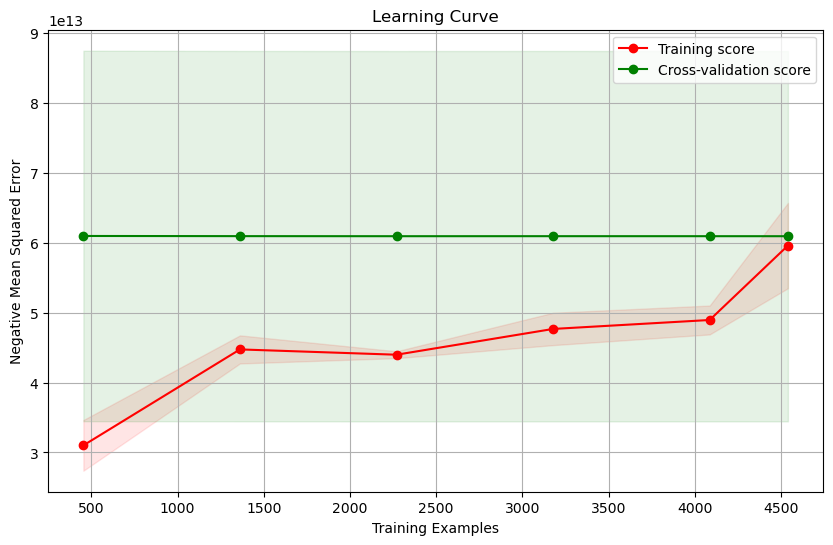

In [8]:
#visualise this models learning curve
train_sizes, train_scores, test_scores = learning_curve(
    SVR(), X, y, train_sizes=[0.1, 0.3, 0.5, 0.7, 0.9, 1], 
    cv=5, scoring='neg_mean_squared_error', random_state=42
)

print(f"Training Sizes: {train_sizes} \n Training Scores: {train_scores} \n test_scores : {test_scores}")

# Calculate mean and standard deviation for training set scores and validation set scores
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plotting
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Negative Mean Squared Error")
plt.legend(loc="best")
plt.grid(True)
plt.show()

R^2 Score: 0.6122206909893722
Mean Squared Error: 36571888521032.23


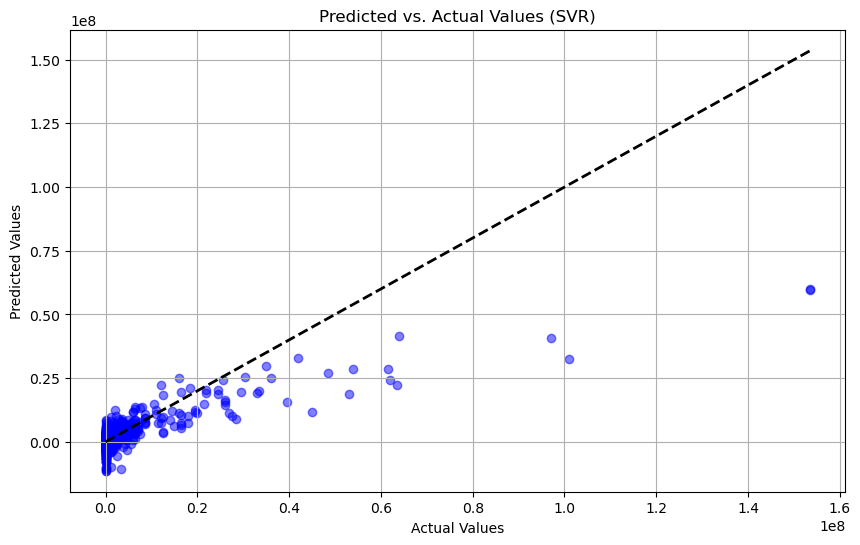

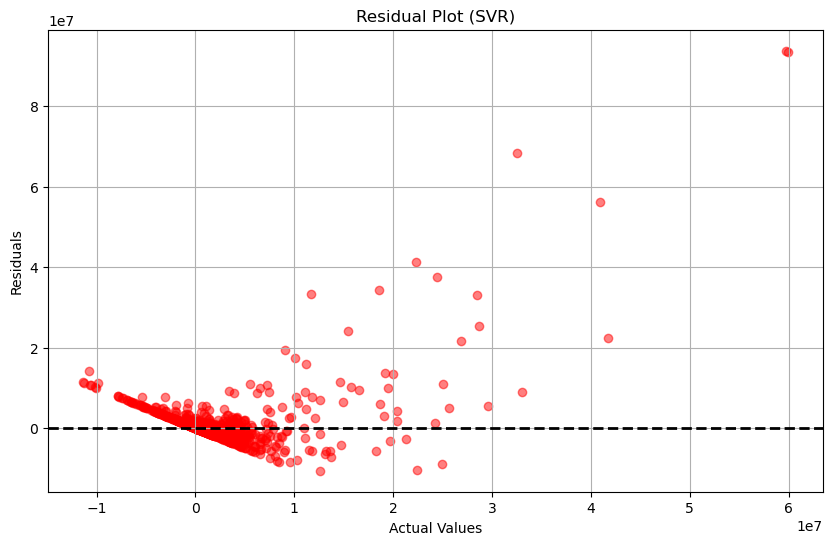

In [9]:
# Predictions
y_pred = best_svm_model.predict(X_valid_scaled)

# Evaluate with different metrics
r2_score = r2_score(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
print(f"R^2 Score: {r2_score}")
print(f"Mean Squared Error: {mse}")


# Plotting the Predicted vs. Actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, color='blue', alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values (SVR)')
plt.grid(True) 
plt.show()

# Calculate residuals
residuals = y_valid - y_pred

# Plotting the Residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='red', alpha=0.5)
plt.axhline(y=0, color='k', linestyle='--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Plot (SVR)')
plt.grid(True)
plt.show()